In [2]:
import pylab
import pymoc
import xidplus
import numpy as np
%matplotlib inline

/home/mc741/anaconda3/lib/python3.6/site-packages/mpl_toolkits/axes_grid/__init__.py:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  obj_type='module')


This notebook uses all the raw data from the masterlist, maps, PSF and relevant MOCs to create XID+ prior object and relevant tiling scheme

## Read in MOCs
The selection functions required are the main MOC associated with the masterlist. Here we use the SERVS depth.

In [2]:
Sel_func=pymoc.MOC()
Sel_func.read('../../dmu4/dmu4_sm_ELAIS-N2/data/holes_ELAIS-N2_irac_i1_O16_20180921_MOC.fits')
SWIRE_MOC=pymoc.MOC()
SWIRE_MOC.read('../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SWIRE_ELAIS-N2_MOC.fits')

In [3]:
Final=Sel_func.intersection(SWIRE_MOC)

In [ ]:
Final.write('./data/testMoc.fits', overwrite=True)

## Read in Masterlist
Next step is to read in Masterlist and select only sources that are detected in mid-infrared and at least one other wavelength domain (i.e. optical or nir). This will remove most of the objects in the catalogue that are artefacts. We can do this by using the `flag_optnir_det` flag and selecting sources that have a binary value of $>= 5$

In [2]:
from astropy.io import fits
masterfile='master_catalogue_elais-n2_20180218.fits'
masterlist=fits.open('../../dmu1/dmu1_ml_ELAIS-N2/data/'+masterfile)

In [5]:
good=masterlist[1].data['flag_optnir_det']>=5

### Create uninformative (i.e. conservative) upper and lower limits based on IRAC fluxes
As the default flux prior for XID+ is a uniform distribution, it makes sense to set reasonable upper and lower 24 micron flux limits based on the longest wavelength IRAC flux available. For a lower limit I take IRAC/500.0 and for upper limit I take IRACx500.

In [6]:
MIPS_lower=np.full(good.sum(),0.0)
MIPS_upper=np.full(good.sum(),1E5)

In [7]:
#masterlist[1].header

In [8]:
#for i in range(0,good.sum()):
#    if masterlist[1].data['flag_irac4'][good][i]>0:
#        MIPS_lower[i]=masterlist[1].data['f_irac4'][good][i]/500.0
#        MIPS_upper[i]=masterlist[1].data['f_irac4'][good][i]*500.0
#    elif masterlist[1].data['flag_irac3'][good][i]>0:
#        MIPS_lower[i]=masterlist[1].data['f_irac3'][good][i]/500.0
#        MIPS_upper[i]=masterlist[1].data['f_irac3'][good][i]*500.0
#    elif masterlist[1].data['flag_irac2'][good][i]>0:
#        MIPS_lower[i]=masterlist[1].data['f_irac2'][good][i]/500.0
#        MIPS_upper[i]=masterlist[1].data['f_irac2'][good][i]*500.0
#    elif masterlist[1].data['flag_irac1'][good][i]>0:
#        MIPS_lower[i]=masterlist[1].data['f_irac1'][good][i]/500.0
#        MIPS_upper[i]=masterlist[1].data['f_irac1'][good][i]*500.0

In [9]:
for i in range(0,good.sum()):
    if ~np.isnan(masterlist[1].data['f_irac_i4'][good][i]):
        MIPS_lower[i]=masterlist[1].data['f_irac_i4'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i4'][good][i]*500.0
    elif ~np.isnan(masterlist[1].data['f_irac_i3'][good][i]):
        MIPS_lower[i]=masterlist[1].data['f_irac_i3'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i3'][good][i]*500.0
    elif ~np.isnan(masterlist[1].data['f_irac_i2'][good][i]):
        MIPS_lower[i]=masterlist[1].data['f_irac_i2'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i2'][good][i]*500.0
    elif ~np.isnan(masterlist[1].data['f_irac_i1'][good][i]):
        MIPS_lower[i]=masterlist[1].data['f_irac_i1'][good][i]/500.0
        MIPS_upper[i]=masterlist[1].data['f_irac_i1'][good][i]*500.0

## Read in Map
We are now ready to read in the MIPS map


In [3]:
MIPS_Map=fits.open('../../dmu17/dmu17_HELP_Legacy_Maps/ELAIS-N2/data/input_data/swire_EN2_M1_v4_help.fits')

NameError: name 'fits' is not defined

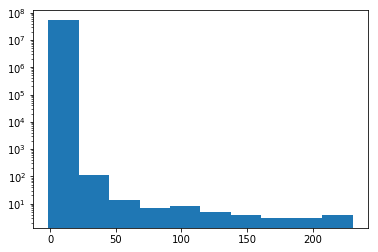

In [5]:
from matplotlib import pyplot as plt
data=MIPS_Map[1].data
plt.hist(data.flatten());
plt.yscale('log')

In [10]:
MIPS_Map[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6038                                                  
NAXIS2  =                 9283                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
TELESCOP= 'Spitzer '           / Spitzer Space Telescope                        
INSTRUME= 'MIPS    '           / Spitzer Space Telescope instrument ID          
CHNLNUM =                    1 / This image: 1=24um,2=70um,3=160um              
EXPTYPE = 'scn     '           / Exposure Type                                  
FOVID   =                  113 / Field of View ID for Commanded Pointing        
FOVNAME = 'MIPS_70um_scan'  

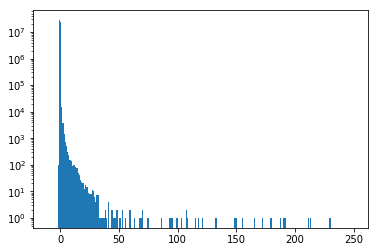

In [6]:
data=MIPS_Map[1].data
plt.hist(data.flatten(),bins=np.arange(-10.0,250.0,1.0));
plt.yscale('log')

## Read in PSF

In [9]:
MIPS_psf=fits.open('../../dmu17/dmu17_HELP_Legacy_Maps/ELAIS-N2/data/dmu17_MIPS_ELAIS-N2_20181029.fits')

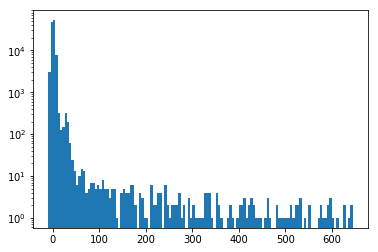

In [13]:
dat=MIPS_psf[1].data
plt.hist(dat.flatten(),bins=np.arange(-10.0,650.0,5.0));
plt.yscale('log')

In [1]:
np.mean(~np.isnan(dat))

NameError: name 'np' is not defined

In [12]:
centre=np.long((MIPS_psf[1].header['NAXIS1']-1)/2)
radius=20

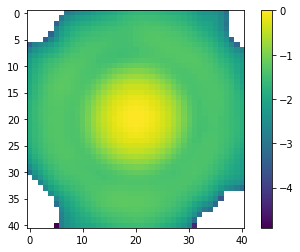

In [13]:
import pylab as plt
plt.imshow(np.log10(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/np.max(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1])))
plt.colorbar()

## Set XID+ prior class

In [14]:
prior_MIPS=xidplus.prior(MIPS_Map[1].data,MIPS_Map[2].data,MIPS_Map[0].header,MIPS_Map[1].header,moc=Final)
prior_MIPS.prior_cat(masterlist[1].data['ra'][good],masterlist[1].data['dec'][good],masterfile,flux_lower=MIPS_lower,
                     flux_upper=MIPS_upper,ID=masterlist[1].data['help_id'][good])


In [15]:
prior_MIPS.set_prf(MIPS_psf[1].data[centre-radius:centre+radius+1,centre-radius:centre+radius+1]/1.0E6,np.arange(0,41/2.0,0.5),np.arange(0,41/2.0,0.5))

## Calculate tiles
As fitting the whole map would be too computationally expensive, I split based on HEALPix pixels. For MIPS, the optimum order is 11. So that I don't have to read the master prior based on the whole map into memory each time (which requires a lot more memory) I also create another layer of HEALPix pixels based at the lower order of 6.

In [16]:
import pickle
#from moc, get healpix pixels at a given order
from xidplus import moc_routines
order=11
tiles=moc_routines.get_HEALPix_pixels(order,prior_MIPS.sra,prior_MIPS.sdec,unique=True)
order_large=6
tiles_large=moc_routines.get_HEALPix_pixels(order_large,prior_MIPS.sra,prior_MIPS.sdec,unique=True)
print('----- There are '+str(len(tiles))+' tiles required for input catalogue and '+str(len(tiles_large))+' large tiles')
output_folder='./data/'
outfile=output_folder+'Master_prior.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'priors':[prior_MIPS],'tiles':tiles,'order':order,'version':xidplus.io.git_version()},f)
outfile=output_folder+'Tiles.pkl'
with open(outfile, 'wb') as f:
    pickle.dump({'tiles':tiles,'order':order,'tiles_large':tiles_large,'order_large':order_large,'version':xidplus.io.git_version()},f)
raise SystemExit()

----- There are 5442 tiles required for input catalogue and 13 large tiles


SystemExit: 

In [17]:
prior_MIPS.nsrc

128252